Normalized confusion matrix
[[0.56260494 0.2314761  0.03782806 0.         0.14153027 0.02656063
  0.         0.         0.         0.         0.        ]
 [0.42639449 0.36964562 0.04594676 0.         0.1398229  0.01819022
  0.         0.         0.         0.         0.        ]
 [0.46641193 0.19023151 0.19360159 0.         0.12622373 0.02353123
  0.         0.         0.         0.         0.        ]
 [0.4617037  0.22864218 0.0823391  0.         0.19828152 0.02903349
  0.         0.         0.         0.         0.        ]
 [0.26711028 0.09122732 0.01015471 0.         0.60984429 0.02166339
  0.         0.         0.         0.         0.        ]
 [0.37802597 0.24242112 0.05884674 0.         0.2518915  0.06881466
  0.         0.         0.         0.         0.        ]
 [0.34933051 0.14132308 0.04650669 0.         0.40906801 0.05377171
  0.         0.         0.         0.         0.        ]
 [0.36353699 0.19282157 0.05064982 0.         0.31926394 0.07372768
  0.         0.       

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

          1       0.44      0.56      0.49    253119
          6       0.25      0.37      0.30    112478
          7       0.37      0.19      0.25     84271
          5       0.00      0.00      0.00     73088
          4       0.24      0.61      0.34     60563
          3       0.18      0.07      0.10     58287
         11       0.00      0.00      0.00     37715
          2       0.00      0.00      0.00     16466
          8       0.00      0.00      0.00     11079
          9       0.00      0.00      0.00      2829
         10       0.00      0.00      0.00      1476

avg / total       0.27      0.34      0.29    711371



/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

          1       0.44      0.56      0.49    760092
          6       0.25      0.37      0.30    337174
          7       0.37      0.19      0.26    253090
          5       0.00      0.00      0.00    219347
          4       0.24      0.61      0.34    181469
          3       0.18      0.07      0.10    175692
         11       0.00      0.00      0.00    111749
          2       0.00      0.00      0.00     49896
          8       0.00      0.00      0.00     32567
          9       0.00      0.00      0.00      8415
         10       0.00      0.00      0.00      4621

avg / total       0.27      0.34      0.29   2134112



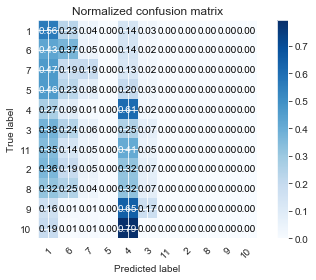

In [6]:

import pandas as pd
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline
from imblearn.over_sampling import SMOTE, ADASYN
from plot_confusion_matrix import *
import time

# step 1. imported all data
start_time = time.time()

df_batter = pd.read_csv('atbats.csv')
df_names = pd.read_csv('player_names.csv')
df_names.columns = ["pitcher_id", "first_name", "last_name"]
df_batter_pitcher= df_batter.merge(df_names, on = 'pitcher_id', how = 'left')
df_pitches = pd.read_csv('pitches.csv')
df_full= df_batter_pitcher.merge(df_pitches, on = 'ab_id', how = 'left')

# step 2. created a dummy variable
dummy = pd.get_dummies(df_full['type'])
df_full = df_full.merge(dummy, left_index = True, right_index = True)

# step 3. rename columns
df_full.rename(columns =({'p_score': 'Pitcher_Score'}),inplace = True)
df_full.rename(columns =({'b_score': 'Batter_Score'}),inplace = True)
df_full.rename(columns =({'b_count': 'Ball_Count'}),inplace = True)
df_full.rename(columns =({'s_count': 'Strike_Count'}),inplace = True)

# step 4. drop columns
column_names = ['ab_id','p_throws', 'stand', 'type', 'event', 'g_id', 'o', 'top', 'first_name', 'last_name',
       'px', 'pz', 'start_speed', 'end_speed', 'spin_rate', 'spin_dir',
       'break_angle', 'break_length', 'break_y', 'ax', 'ay', 'az', 'sz_bot',
       'sz_top', 'type_confidence', 'vx0', 'vy0', 'vz0', 'x', 'x0', 'y', 'y0',
       'z0', 'pfx_x', 'pfx_z', 'nasty', 'zone', 'code',
       'event_num', 'pitch_num']
df_full = df_full.drop(columns=column_names, axis=1)

# step 5. drop rows
df_full = df_full[(df_full['pitch_type'] != 'FA') & 
                  (df_full['pitch_type'] != 'AB') &
                  (df_full['pitch_type'] != 'UN') &
                  (df_full['pitch_type'] != 'SC') &
                  (df_full['pitch_type'] != 'FO') &
                  (df_full['pitch_type'] != 'PO') &
                  (df_full['pitch_type'] != 'EP')]

# step 6. add prev_pitch
df_full['prev_pitch'] = df_full['pitch_type'].shift(1)
df_full.dropna(inplace=True)

# step 7. convert categorical variable into numeric variable
score_to_numeric = {
    "FF" : 1,
    "SL" : 2,
    "FT" : 3,
    "CH" : 4,
    "SI" : 5,
    "CU" : 6,
    "FC" : 7,
    "KC" : 8,
    "FS" : 9,
    "KN" : 10,
    "IN" : 11
}

df_full['prev_pitch'] = df_full['prev_pitch'].apply(lambda x : score_to_numeric[x])
df_full['pitch_type'] = df_full['pitch_type'].apply(lambda x : score_to_numeric[x])

# step 9. prepare for training

target = df_full['pitch_type']
df_full.drop('pitch_type', axis = 1, inplace = True)
df_full_copy = df_full
df_full_copy = df_full_copy.drop(columns=["pitcher_id", "batter_id"])

data_train, data_test, target_train, target_test = train_test_split(df_full_copy,
                                                                    target,
                                                                    test_size = 0.25, 
                                                                    random_state=123)


# step 10. training
sampling_matrix = {
    1: 0.05,
    2: 0.1,
    3: 0.1,
    4: 0.1,
    5: 0.125,
    6: 0.125,
    7: 0.1,
    8: 0.075,
    9: 0.075,
    10: 0.075,
    11: 0.075
}

forest = RandomForestClassifier(class_weight=sampling_matrix,
                                n_estimators=300, 
                                max_depth=4)

forest.fit(data_train, target_train)

# step 11. predictions
y_test = forest.predict(data_test)
y_train = forest.predict(data_train)
target_list = list(target.unique())

# step 12. visualizations

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    # classes = np.array(classes)[unique_labels(np.array(y_true), y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

plot_confusion_matrix(np.array(target_test), 
                      y_test,
                      target_list,
                      normalize=True,
                      title=None,
                      cmap=plt.cm.Blues)


print(f"program took {time.time() - start_time} seconds to complete!")

#step 13. classification reports
print(classification_report(list(target_test), list(y_test), target_names=[str(i) for i in target_list]))
print(classification_report(list(target_train), list(y_train), target_names=[str(i) for i in target_list]))